In [7]:
import numpy as np
import matplotlib.pyplot as plt
from phi.tf.flow import *

In [8]:
N =500
DX = 2./N
STEPS = 100
DT = 2./STEPS
NU = 0.01/(N*np.pi)

# initialization of velocities, cell centers of a CenteredGrid have DX/2 offsets for linspace()
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) + np.cos(x) + np.cos(2 * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D numpy array


INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor

velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
vt = advect.semi_lagrangian(velocity, velocity, DT)

#velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1))) # random init

print("Velocity tensor shape: "   + format( velocity.shape )) # == velocity.values.shape
print("Velocity tensor type: "    + format( type(velocity.values) ))
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy('x')[10:15] ))

velocities = [velocity]
age = 0.
for i in range(STEPS):
    v1 = diffuse.explicit(velocities[-1], NU, DT)
    v2 = advect.semi_lagrangian(v1, v1, DT)
    age += DT
    velocities.append(v2)

print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy('x,vector')[0:5] ))


Velocity tensor shape: (xˢ=500)
Velocity tensor type: <class 'phiml.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.36833325 0.39158604 0.414828   0.43805662 0.46126947]
New velocity content at t=2.0000000000000013: [[0.07776817]
 [0.07793663]
 [0.07815717]
 [0.07842472]
 [0.07873499]]


In [6]:
print(velocities)

[CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredGrid[(xˢ=500), size=(x=2) int64, extrapolation=periodic], CenteredG

New velocity content at t=2.0000000000000013: [[0.07776804]
 [0.07793646]
 [0.07815696]
 [0.07842448]
 [0.07873471]]


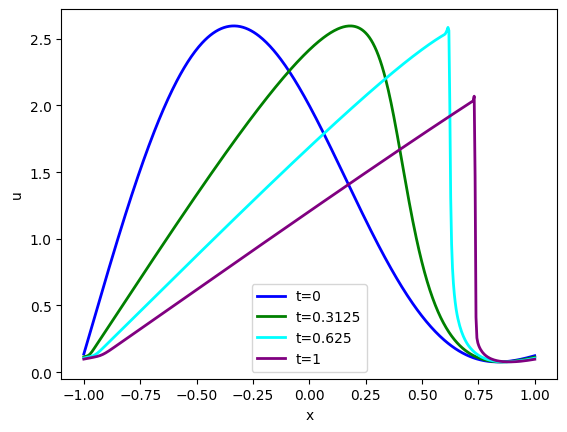

In [16]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector"
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays 

import pylab

fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue',  label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan',  label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[92].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

In [18]:
import numpy as np
from phi.flow import *


def random_fourier_series(terms, x):
    amplitude = np.random.uniform(-1, 1, terms)
    phase = np.random.uniform(-np.pi, np.pi, terms)
    frequencies = np.arange(1, terms + 1)
    fourier_val = np.sum([a * np.sin(f * np.pi * x + p) for a, f, p in zip(amplitude, frequencies, phase)], axis=0)
    return fourier_val
def generate_data(N_high, N_low, STEPS, terms):
    DX_high = 2.0 / N_high
    DX_low = 2.0 / N_low
    DT = 1/25
    NU_high = 0.10 / (N_high * np.pi)
    NU_low = 0.10 / (N_low * np.pi)
    
    # Generate initial condition based on the provided function
    x_domain_high = np.linspace(-1 + DX_high / 2, 1 - DX_high / 2, N_high)
    INITIAL_NUMPY_high = random_fourier_series(terms, x_domain_high)
    INITIAL_high = math.tensor(INITIAL_NUMPY_high, spatial('x'))

    # Downsample the high-resolution initial state to create the low-resolution initial state
    INITIAL_NUMPY_low = INITIAL_NUMPY_high[::N_high // N_low]
    INITIAL_low = math.tensor(INITIAL_NUMPY_low, spatial('x'))

    # Initialize velocity grid
    velocity_high = CenteredGrid(INITIAL_high, extrapolation.PERIODIC, x=N_high, bounds=Box(x=(-1, 1)))
    velocity_low = CenteredGrid(INITIAL_low, extrapolation.PERIODIC, x=N_low, bounds=Box(x=(-1, 1)))
    velocities_high = [velocity_high]
    velocities_low = [velocity_low]
    age = 0.0

    for i in range(STEPS):
        v1_high = diffuse.explicit(velocities_high[-1], NU_high/10, DT)
        v2_high = advect.semi_lagrangian(v1_high, v1_high, DT)
        v1_low = diffuse.explicit(velocities_low[-1], NU_low/10, DT)
        v2_low = advect.semi_lagrangian(v1_low, v1_low, DT)
        age += DT
        velocities_high.append(v2_high)
        velocities_low.append(v2_low)

    return velocities_high, velocities_low

N_high = 200
N_low = 50
STEPS = 600

# Generate data with specified grid size, number of steps, and initial condition
data_high, data_low = generate_data(N_high, N_low, STEPS, 10)


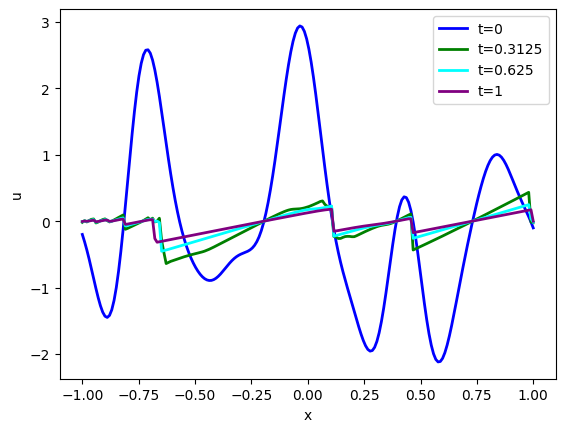

In [19]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector"
vels = [v.values.numpy('x,vector') for v in data_high] # gives a list of 2D arrays 

import pylab

fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue',  label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan',  label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

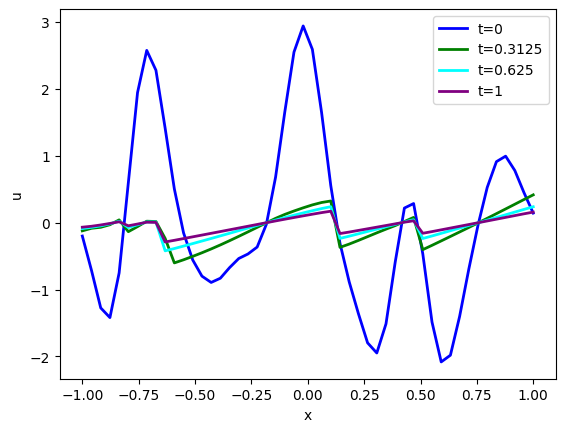

In [20]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector"
vels = [v.values.numpy('x,vector') for v in data_low] # gives a list of 2D arrays 

import pylab

fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue',  label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan',  label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

In [27]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector"
vels_high = [v.values.numpy('x,vector') for v in data_high] # gives a list of 2D arrays 
vels_low = [v.values.numpy('x,vector') for v in data_low] # gives a list of 2D arrays 

# Slice the high resolution data to the shape of the low resolution data
sliced_high = [high[::2, ::2] for high in vels_high]

# Check if the dimensions match
for high, low in zip(sliced_high, vels_low):
    assert high.shape == low.shape, f"Shapes do not match: {high.shape} vs {low.shape}"

# Calculate the difference between high and low resolution data for each timestep
diff_vels = [high - low for high, low in zip(sliced_high, vels_low)]

AssertionError: Shapes do not match: (100, 1) vs (50, 1)

In [26]:
from tensorflow.keras import datasets, layers, models
import tensorflow as tf

def predict_coefficients(input: tf.Tensor,
                         equation: tf.keras.Model) -> tf.Tensor:
    """
    Predict the Coefficient of the Discretization
    """
    
    # Construct the Neural Network
    network = models.Sequential()
    network.add(layers.Conv1D(32, 5, activation='relu', input_shape=(input.shape[1], input.shape[2])))
    network.add(layers.Conv1D(32, 5, activation='relu'))
    network.add(layers.Conv1D(32, 5, activation='relu'))
    return 0


    
    
def train_steps(data: tf.Tensor,
                diff: tf.Tensor,
                optimizer: tf.keras.optimizers.Optimizer,
                epochs: int) -> tf.Tensor:
    """
    Train the Neural Network
    """
    data = tf.convert_to_tensor(data, dtype=tf.float32)
    diff = tf.convert_to_tensor(diff, dtype=tf.float32)
    # Construct the Neural Network
    network = models.Sequential()
    network.add(layers.Conv1D(32, 5, activation='relu', input_shape=(data.shape[1], data.shape[2])))
    network.add(layers.Conv1D(32, 5, activation='relu'))
    network.add(layers.Conv1D(32, 5, activation='relu'))
    network.add(layers.Conv1D(1, 5, activation='relu'))

    # Compile the Neural Network
    network.compile(optimizer=optimizer,
                    loss='mean_squared_error')
    
    # Train the Neural Network
    network.fit(data, diff, epochs=epochs)
    
    return network

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Train the Neural Network
trained_network = train_steps(data_high, diff_vels, optimizer, 100)


NameError: name 'diff_vels' is not defined

In [9]:
import numpy as np

np.random.seed(0)

# Test number
N = 1

random = np.random.uniform(-1, 1, N)
random2 = np.random.uniform(-1, 1, N)
print(random)
print(random2)

[0.09762701]
[0.43037873]
